# TD7: Machine Learning with TDA

The goal of this lab session is to use persistent homology to derive stable signatures for 3D shape classification.


Throughout this lab, we will use `Gudhi`. It provides functions to vectorize persistence diagrams with `Scikit-Learn` estimator-like classes, that is, with classes that have `fit`, `transform`, and `fit_transform` methods, see [this article](https://arxiv.org/pdf/1309.0238.pdf) for more details.


Requirements:
```bash
gudhi
numpy
scikit-learn
matplotlib
plotly
```


In [1]:
!pip install gudhi
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install plotly

In [2]:
import os

import sklearn
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import decomposition
from sklearn.manifold import MDS
from sklearn.neighbors import KNeighborsClassifier


# -- TDA packages
import gudhi
import gudhi.representations
from gudhi.representations import DiagramSelector

In [3]:
def seed_everything(seed: int):
    """fix the seed for reproducibility."""
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## I.0. Preprocessing & exploration of the dataset

### Q.0. Download & set-up the access to the data

#### For Colab users

Q.0.1 If you use **colab**:

- *Mount your Google Drive* to allow Colab to access files in your Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- *Access the [folder](https://drive.google.com/drive/folders/1oW5FTPNbIRPjFzlhzFLYRBkZ9iRMw3Q6?usp=drive_link)* with the data, this will automatically add it to your 'shared folder'
- *Locate the Shared Folder* which is tipically stored under `My Drive > Shared with me`.
- *Add the Shared Folder to 'My Drive'*.
Drag & drop the folder in 'My Drive' folder. (Only items in "My Drive" or folders you’ve added to your Drive can be accessed directly.)
- The folder with the data should now be in *My Drive/LabeledDB_new*

In [5]:
dataset_path = '/content/drive/My Drive/LabeledDB_new'

#### For local users

Q.0.1 If you use your **own machine**
- Download the data from [here](https://drive.google.com/file/d/1LnRsKQTEMLjSMtt5J6cvkIzY7YtxNoML/view?usp=sharing)
- Extract it
- Save its path in the `dataset_path` variable

In [ ]:
dataset_path = "/Users/julie/Documents/PhD/01_TA/INF556/TD7/data/LabeledDB_new"

#### Read the data

Q.0.2 Verify everyting is set-up properly by listing the subdirectories in the file (it should contain 10 subdirectories, one for each class)


In [6]:
os.listdir(dataset_path)

['Human',
 'Plier',
 'Mech',
 'Table',
 'Vase',
 'FourLeg',
 'Chair',
 'Fish',
 'Ant',
 'Airplane']

Q.1 Write a function `read_data`, which takes as input the path to a shape and returns two `NumPy` arrays containing respectively the vertices and the faces.


Note. The dataset in split in 10 categories (Ant, Hand, Plier, Chair, Vase, Bird, FourLeg, Table, Airplane, Octopus), each category having its own folder. Inside each folder, some 3D shapes (i.e., 3D triangulations) are provided in [`.off`](https://en.wikipedia.org/wiki/OFF_(file_format)) format.

Each file are structured as follows:
- OFF is the standard signature for .off files,
- (n_v, n_f, _) where n_v and n_f are respectively the numbers of vertices and triangles in the mesh,
- the vertices (x_n y_n z_n),  are the coordinates of the nth vertex
- the faces (i_m j_m k_m) are the IDs of the three vertices representing the mth triangle. For instance, 3 14 0 5 denotes the triangle that is given by the 14th, 0th and 5th vertices.



In [7]:
def read_data(path):
    """
    Read a .off file and return the vertices and faces
    as numpy arrays given the path.

    Parameters
    ----------
    path: str
        Path to the shape file.

    Returns
    -------
    vertices: numpy array
        Array of vertices.
    faces: numpy array
        Array of faces.
    """
    with open(path, 'r') as content:
        content.readline()
        # content.readline() # remoeve this line for LabelNew
        num_vertices, num_faces, _ = [int(n) for n in content.readline().split(' ')]
        info = content.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces

Q.2 Get the vertices and faces of the shape of your choice.

In [8]:
vertices, faces = read_data(dataset_path + "/Airplane/61.off")

Q.3. Visualize a 3D shape. Write a function `plot_3d_shape` which takes as input the vertices and faces of a shape and plots it using the `plotly` library (with `go.Mesh3d`). Visualize the shape (selected in Q.2).


In [9]:
def plot_3d_shape(vertices, faces):
    """
    Plot a mesh given its vertices and faces.

    Parameters
    ----------
    vertices: numpy array
        Vertices of the mesh.
    faces: numpy array
        Faces of the mesh

    """
    fig = go.Figure(data=[go.Mesh3d(x=vertices[:,0],
                                    y=vertices[:,1],
                                    z=vertices[:,2],
                                    i=faces[:,0],
                                    j=faces[:,1],
                                    k=faces[:,2],
                                    color='blue', opacity=0.50)])
    fig.show()

plot_3d_shape(vertices, faces)

## I.1. Compute the persistence diagrams

Let's now compute the persistence diagrams for the 3D shapes.

Q.4 Write a function `get_simplex_tree_from_faces` function that builds a simplex tree from the faces of a given 3D shape triangulation.

Note. In `Gudhi`, (filtered) simplicial complexes are encoded through a data structure called simplex tree.
See the [`gudhi.SimplexTree()`](https://gudhi.inria.fr/python/latest/simplex_tree_ref.html) for a complete list of functionalities

Here is a very simple example illustrating the use of `gudhi.SimplexTree()` to represent a simplicial complex:
```python
st = gudhi.SimplexTree() # create a simplex tree

# simplices can be inserted one by one
# vertices are indexed by integers
if st.insert([0,1]):
  print("first simplex inserted!")

st.insert([1,2])
st.insert([2,3])
st.insert([3,0])

filtration = st.get_filtration() # Get a list with all the simplices
# Inserting an edge automatically insert its vertices (if they were
# not already in the complex)
for simplex in filtration:
  print(simplex)

# insert the 2-skeleton giving some filtration values to the faces
st.insert([0,1,2], filtration=0.1)
st.insert([1,2,3], filtration=0.2)

# if you add a new simplex with a given filtration values, all its faces that
# were not in the complex before are added with the same filtration value
st.insert([2,3,4],filtration=0.7)
```

In [ ]:
def get_simplex_tree_from_faces(faces):
    """Bluids a simplex tree from a list of faces.

    Parameters
    ----------
    faces : numpy array
        faces of the shape

    Returns
    -------
    simplex_tree : gudhi.SimplexTree
        The simplex tree.
    """
    simplex_tree = gudhi.SimplexTree()
    for face in faces:
        # when we add a new simplex with a given filtration value, 
        # all its faces that were not already in the complex 
        # are added with the same filtration value
        simplex_tree.insert(face, -1e10) # can leave 0 as default value
    return simplex_tree


In [11]:
vertices, faces = read_data(dataset_path + "/Airplane/61.off")
get_simplex_tree_from_faces(faces)

Q.5. Write a function `compute_persistence_diagram` which takes as input the path of the shape and returns the persistence diagram of the shape in **degree 1.**

We will use a lower-star filtration based on the eccentricity of the vertices. The eccentricity of a vertex is the maximum distance to any other vertex in the shape.

You can follow the steps:
- use `read_path`, to access the vertices and faces of the shape
- use `get_simplex_tree_from_faces`, to get the simplex tree
- assign the filtration value to each vertex
- use `make_filtration_non_decreasing` to ensure the filtration is non-decreasing
- compute the persistence

In [ ]:
def compute_persistence_diagram(path):
    """
    Compute the persistence diagram of a shape.

    Parameters
    ----------
    path: path where the .off file of the shape is stored.

    Returns
    -------
    The persistence in dimension 1.
    """
    vertices, faces = read_data(path)

    st = get_simplex_tree_from_faces(faces)

    distances = sklearn.metrics.pairwise_distances(vertices, vertices)
    filtration = np.max(distances, axis=1)

    for v in range(len(vertices)):
        # modify the filtration value of any simplex 
        # included in the tree with the assign_filtration()
        st.assign_filtration([v], filtration[v])
    # att: since we modify the filtration values, we need to make sure that the filtration is non-decreasing
    # for example if we modify [3], its filtration value can become > [2 3]
    # make_filtration_non_decreasing() method to solve the problem
    st.make_filtration_non_decreasing()
    st.persistence()
    return st.persistence_intervals_in_dimension(1) # return the persistence diagram of dimension 1

Q.5.1 Compute the persistence diagram of your choice and display it. You can use `gudhi.plot_persistence_diagram`.

/usr/local/lib/python3.10/dist-packages/gudhi/persistence_graphical_tools.py:107: UserWarning:

usetex mode requires TeX.



<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

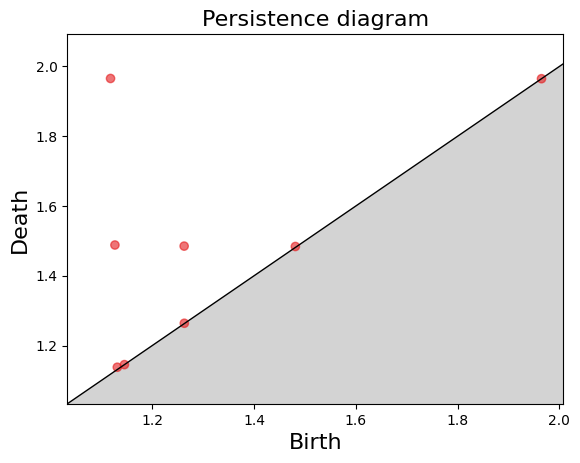

In [13]:
persistence_diagram = compute_persistence_diagram(dataset_path + "/Airplane/61.off")
gudhi.plot_persistence_diagram(persistence_diagram)

Q.6 Compute the persistence diagrams of all shapes. Write the function `get_persistence_diagrams` which takes as input the path  where the shapes are stored, and returns the `persistence diagrams` of all shapes as well as the corresponding labels and ids. Run the function on all the shapes.


In [14]:
def get_persistence_diagrams(path, filter_class=[]):
    """
    Get the persistence of a diagram.

    Parameters
    ----------
    path: str
        Path to the shape file.
    filter_class: []
        if not empty, only the classes in the list will be considered otherwise you can consider specific classes.

    Returns
    -------
    diagrams: list
        List of persistence diagrams.
    labels: list
        List of labels.
    ids: list
        List of ids. (can be of the frorm class + id of the shape)
    """
    classes = os.listdir(path)
    if len(filter_class) > 0:
        classes = filter_class
    print(classes)
    diagrams = []
    labels = []
    ids = []
    for c in classes:
        print(f"Processing class {c}")
        shapes = os.listdir(os.path.join(path, c))
        for shape in shapes:
            path_shape = os.path.join(path, c, shape)
            if path_shape.endswith('.off'):
                diag = compute_persistence_diagram(path_shape)
                diagrams.append(diag)
                labels.append(c)
                ids.append(f"{c}_{shape}")
    return diagrams, labels, ids

In [15]:
all_categories = os.listdir(dataset_path)
diagrams, labels, ids = get_persistence_diagrams(dataset_path)

['Human', 'Plier', 'Mech', 'Table', 'Vase', 'FourLeg', 'Chair', 'Fish', 'Ant', 'Airplane']
Processing class Human
Processing class Plier
Processing class Mech
Processing class Table
Processing class Vase
Processing class FourLeg
Processing class Chair
Processing class Fish
Processing class Ant
Processing class Airplane


## II.2. Bottleneck distance and first classification

It is not convenient to use persistence diagrams directly as a featurization for machine learning purposes. As a first step, we will use the bottleneck distance to compare persistence diagrams, and then use $k$-nearest neighbors classifier to predict the category of a shape.

Q.7 Pick a specific persistence diagram and use `DiagramSelector(use=True, point_type='finite')` to remove its points with infinite coordinates.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

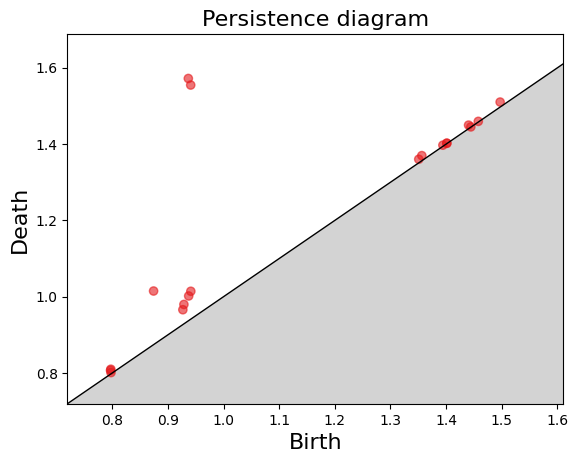

In [16]:
diagram = diagrams[0]
gudhi.plot_persistence_diagram(diagram)

In [17]:
[diagram] = DiagramSelector(use=True, point_type='finite').fit_transform([diagram])

Q.8 Pick another Persistent Diagram, remove the infinit points, and compute the bottleneck distance (`gudhi.representations.BottleneckDistance(epsilon=.001)`)  between them.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

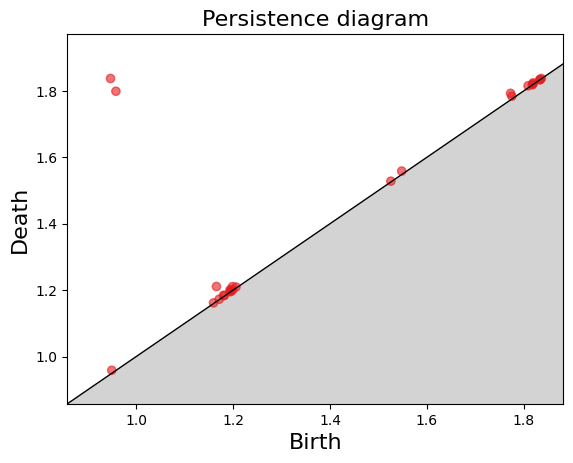

In [18]:
[diagram_bis] = DiagramSelector(use=True, point_type='finite').fit_transform([diagrams[2]])
gudhi.plot_persistence_diagram(diagram_bis)

In [19]:
BD = gudhi.representations.BottleneckDistance(epsilon=.001)
BD.fit([diagram])
bd = BD.transform([diagram_bis])
print("Bottleneck distance is " + str(bd[0][0]))

Bottleneck distance is 0.26552965252481986


Q.9 Apply `MDS` on the bottleneck distance matrices. Display the resulting 2D latent space with the labels.

Note. Don't forget to remove the infinite points of the diagrams, and to encode the labels with value between 0 and n_classes-1. You can use:
```python
import sklearn.preprocessing

le = sklearn.preprocessing.LabelEncoder().fit(labels)
integer_labels = le.transform(labels)
label_indices = [(l,le.classes_[l],np.argwhere(integer_labels==l).ravel()) for l in range(integer_labels.max()+1)]
```

In [20]:
dgms_filtered = DiagramSelector(use=True, point_type='finite').fit_transform(diagrams)
bottleneck_matrix  = gudhi.representations.BottleneckDistance().fit_transform(dgms_filtered)

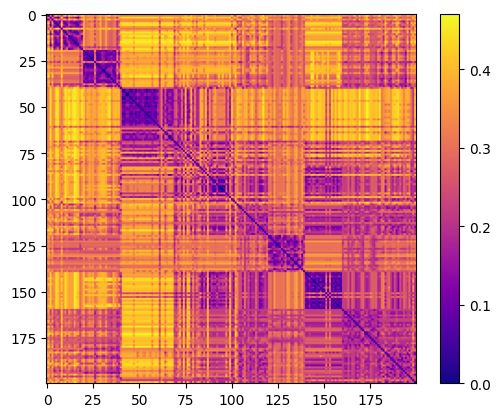

In [ ]:
# check pairwise distances (the diagrams are ordered by the class)
plt.imshow(bottleneck_matrix, cmap='plasma')
plt.colorbar()

<ipython-input-21-435e752e7058>:20: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



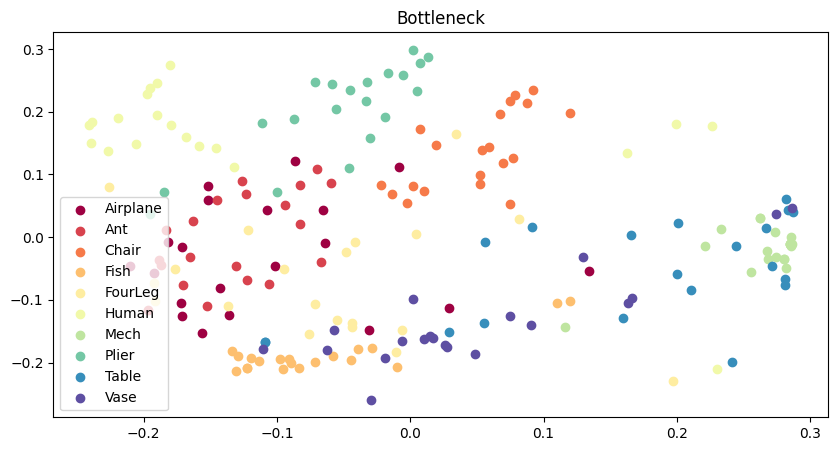

In [21]:
dgms_filtered = DiagramSelector(use=True, point_type='finite').fit_transform(diagrams)

bottleneck_matrix  = gudhi.representations.BottleneckDistance().fit_transform(dgms_filtered)
mds_bottleneck_matrix   = MDS(n_components=2, dissimilarity='precomputed').fit_transform(bottleneck_matrix)
# - encode the labels
le = sklearn.preprocessing.LabelEncoder().fit(labels)
integer_labels = le.transform(labels)
label_indices = [(l, le.classes_[l], np.argwhere(integer_labels==l).ravel()) for l in range(integer_labels.max()+1)]
# - define the color map
import matplotlib as mpl
cmap = mpl.colormaps["Spectral"]
colors = cmap(np.linspace(0, 1, integer_labels.max()+1))
# - plot
plt.figure(figsize=(10,5))
ax1 = plt.subplot(111)
for il,l,li in label_indices:
    ax1.scatter(mds_bottleneck_matrix[li,0], mds_bottleneck_matrix[li,1], label=l, c=colors[il])
ax1.legend()
ax1.set_title('Bottleneck')
plt.show()

Now, let's classify the shapes using the bottleneck distance between the persistence diagrams and a $k$-nearest neighbors classifier!

Q.10 Shuffle the data (use the filtered diagrams and encoded labels from the Q.9) and create a random 80/20 train/test split.

In [22]:
test_size = 0.2
perm = np.random.permutation(len(labels))
limit = int(test_size * len(labels))
test_sub, train_sub = perm[:limit], perm[limit:]
train_labs = np.array(labels)[train_sub]
test_labs = np.array(labels)[test_sub]
train_dgms = [dgms_filtered[i] for i in train_sub]
test_dgms = [dgms_filtered[i] for i in test_sub]

Q.11 Define, train and test a $k$-nearest neighbors classifier.
(Use as input direclty the bottleneck distance between the persistence diagrams, set `metric='precomputed'` in the `KNeighborsClassifier`)

In [23]:
# - bottleneck
distance = gudhi.representations.BottleneckDistance(epsilon=.01).fit(train_dgms)
train_bottleneck = distance.transform(train_dgms)
# - fit the estimator
estimator = KNeighborsClassifier(n_neighbors=4, metric="precomputed")
estimator.fit(train_bottleneck, train_labs)
# - test
test_distances = distance.transform(test_dgms)
y_pred = estimator.predict(test_distances)
accuracy = accuracy_score(test_labs, y_pred)
print("acc = ", accuracy)

acc =  0.75


In [24]:
# with Cross-Validation
distance = gudhi.representations.BottleneckDistance(epsilon=.01).fit_transform(dgms_filtered)
estimator = KNeighborsClassifier(n_neighbors=4, metric="precomputed")
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator, distance, integer_labels, cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.73 (+/- 0.04)


## II.3. Explore vectorization of persistence diagrams

Since it is not convenient to use persistence diagrams directly for machine learning purposes, in this section we will explore different ways to vectorize persistence diagrams. A vecotorization is a map $\Phi: D \rightarrow H$ sending persistence diagrams into a Hilbert space, or equivalently,  a symmetric kernel function $k:D \times D \rightarrow \mathbb{R}$ such that $k(D,D')=\langle \Phi(D),\Phi(D')\rangle$.

For the vectorization mentioned below some hparams are suggested but we recommend you to play with its parameters and infer their influence on the ouput in order to get some intuition.


Q.12 Pick a specific persistence diagram and use `DiagramSelector(use=True, point_type='finite')` to remove its points with infinite coordinates.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

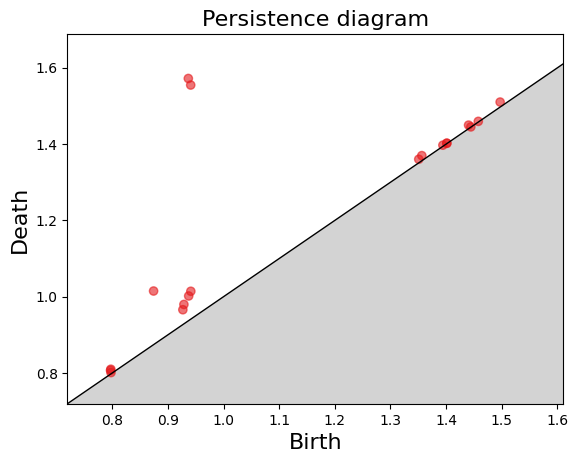

In [25]:
diagram = diagrams[0]
gudhi.plot_persistence_diagram(diagram)

In [26]:
[diagram] = DiagramSelector(use=True, point_type='finite').fit_transform([diagram])

**Silhouette.**  Silhouette are a variation of [persistence landscape](https://www.jmlr.org/papers/volume16/bubenik15a/bubenik15a.pdf). Persistence landscapes are obtained by rotating the persistence diagram by $-\pi/4$
(so that the diagonal becomes the $x$-axis), and then putting tent functions on each point. The $k$ -th landscape is then defined as the $k$-th largest value among all these tent functions. It is eventually turned into a vector by evaluating it on a bunch of uniformly sampled points on the $x$-axis.
Silhouettes take a weighted average of these tent functions instead. Here, we weight each tent function by the distance of the corresponding point to the diagonal.

Q.13 Compute the silhouette of the chosen diagram. Use `gudhi.representations.Silhouette` with `resolution=1000` and use `weight` to weight each tent given the distance to the diagonal.

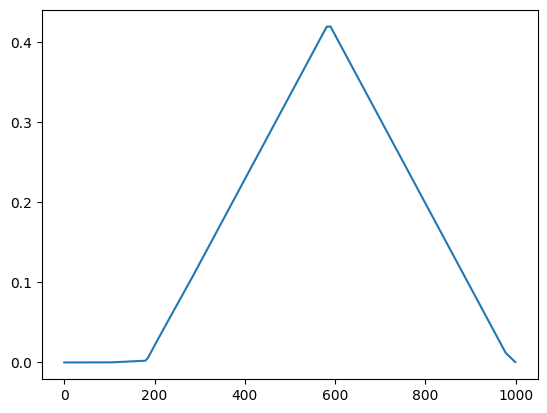

In [27]:
SH = gudhi.representations.Silhouette(resolution=1000, weight=lambda x: np.power(x[1]-x[0],2))
sh = SH.fit_transform([diagram])
# - plot
plt.figure()
plt.plot(sh[0])
plt.show()

[**Sliced Wasserstein Kernel**](https://proceedings.mlr.press/v70/carriere17a/carriere17a.pdf) was introduced in 2017. Sliced Wasserstein kernels use the Sliced Wasserstein approximation of the Wasserstein distance to define a new kernel for PD.

Q.14 Compute the sliced wasserstein kernel of a pair of diagrams. You can use `gudhi.representations.SlicedWassersteinKernel` with ```num_directions=100, bandwidth=1.0```.


In [28]:
SW = gudhi.representations.SlicedWassersteinKernel(bandwidth=1, num_directions=100)
SW.fit([diagram])
sw = SW.transform([diagram_bis])
print("SW kernel is " + str(sw[0][0]))

SW kernel is 0.4928543768014085


Q.15 Apply dimensionality reduction techniques on the explicit maps. Display the resulting 2D latent space with the labels.

Is there any method that looks better in separating the categories, at least by eye? Compare also with the previously 2D latent space obtained when using the bottleneck distance.

Note. Don't forget to remove the infinite points of the diagrams. For the Sliced Wasserstein Kernel featurization use `KernelPCA`. To encode target the labels with value between 0 and n_classes-1, you can use:
```python
import sklearn.preprocessing

le = sklearn.preprocessing.LabelEncoder().fit(labels)
integer_labels = le.transform(labels)
label_indices = [(l,le.classes_[l],np.argwhere(integer_labels==l).ravel()) for l in range(integer_labels.max()+1)]
```

In [29]:
dgms_filtered = DiagramSelector(use=True, point_type='finite').fit_transform(diagrams)

In [30]:
import gudhi.representations

silhouettes = gudhi.representations.Silhouette(resolution=1000, weight=lambda x: np.power(x[1]-x[0],0)).fit_transform(dgms_filtered)
sliced_wass_kernel = gudhi.representations.SlicedWassersteinKernel(num_directions=100).fit_transform(dgms_filtered)
bottleneck_matrix  = gudhi.representations.BottleneckDistance().fit_transform(dgms_filtered)


In [32]:
pca_silhouettes = PCA(n_components=2).fit_transform(silhouettes)
kpca_sliced_wass_kernel = decomposition.KernelPCA(n_components=2).fit_transform(sliced_wass_kernel)
mds_bottleneck_matrix   = MDS(n_components=2, dissimilarity='precomputed').fit_transform(bottleneck_matrix)

In [33]:
le = sklearn.preprocessing.LabelEncoder().fit(labels)
integer_labels = le.transform(labels)
label_indices = [(l,le.classes_[l],np.argwhere(integer_labels==l).ravel()) for l in range(integer_labels.max()+1)]

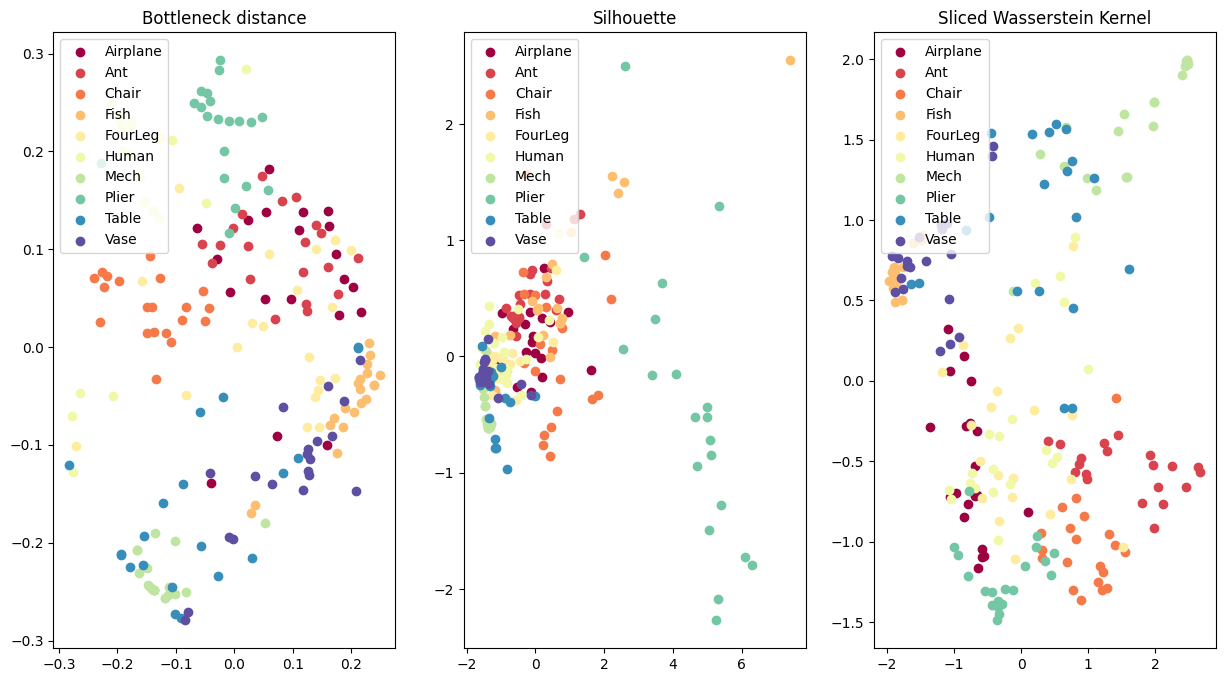

In [36]:
plt.figure(figsize=(15,8))


cmap = mpl.colormaps["Spectral"]
colors = cmap(np.linspace(0, 1, integer_labels.max()+1))

# - bottleneck + MDS
ax_1 = plt.subplot(131)
for il,l,li in label_indices:
    ax_1.scatter(mds_bottleneck_matrix[li,0], mds_bottleneck_matrix[li,1], label=l, color=colors[il])
ax_1.legend(loc=2)
ax_1.set_title('Bottleneck distance')
# - Silhouette + PCA
ax_2 = plt.subplot(132)
for il,l,li in label_indices:
    ax_2.scatter(pca_silhouettes[li,0],
                pca_silhouettes[li,1],
                label=l,
                color=colors[il])
ax_2.legend(loc=2)
ax_2.set_title('Silhouette')
# - SWK + KernelPCA
ax_3 = plt.subplot(133)
for il,l,li in label_indices:
    ax_3.scatter(kpca_sliced_wass_kernel[li,0],
                kpca_sliced_wass_kernel[li,1],
                label=l,
                color=colors[il])
ax_3.legend(loc=2)
ax_3.set_title('Sliced Wasserstein Kernel')

plt.show()

## II.3. Classification

Q.16 Let's try classification now on featurization now! Shuffle the data, and create a random 80/20 train/test split.

In [44]:
test_size = 0.2
perm = np.random.permutation(len(labels))
limit = int(test_size * len(labels))
test_sub, train_sub = perm[:limit], perm[limit:]
train_labs = np.array(labels)[train_sub]
test_labs = np.array(labels)[test_sub]
train_dgms = [dgms_filtered[i] for i in train_sub]
test_dgms = [dgms_filtered[i] for i in test_sub]

Q.17 Let's classify the PD using Sliced Wasserstein Kernels, Silhouettes and simple classifiers!

Define a `Pipeline` with four estimators: one for selecting the finite persistence diagram points, one for scaling (or not) the persistence diagrams (with `DiagramScaler`), one for vectorizing persistence diagrams, and one for performing the final prediction. See the [documentation](https://scikit-learn.org/stable/modules/compose.html#combining-estimators).

Note. Guhdi provides estimator-like classes: they can be integrated flawlessly in a `Pipeline` of `Scikit-Learn` for model selection and cross-validation. A `Pipeline` is itself an estimator, and is initialized as with a list of estimators. It will just sequentially apply the `fit_transform` methods of the estimators in the list.

For the Sliced Wasserstein kernel featurization, use `SVC` with `kernel='precomputed'` in the `Pipeline` as an estimator.

In [43]:
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm


pipe = sklearn.pipeline.Pipeline([("Separator", DiagramSelector(limit=np.inf, point_type="finite")),
                     ("Scaler",    gudhi.representations.DiagramScaler(scalers=[([0,1], sklearn.preprocessing.MinMaxScaler())])),
                     ("TDA",       gudhi.representations.SlicedWassersteinKernel()),
                     ("Estimator", sklearn.svm.SVC())])

Q.17.1 Now, define a grid of parameter (for the different featurizations and estimators) that will be used in cross-validation.

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

param =    [
            {"Separator__use":      [True],
             "Scaler__use":         [False, True],
             "TDA":                 [gudhi.representations.SlicedWassersteinKernel()],
             "TDA__bandwidth":      [0.1, 1.0],
             "TDA__num_directions": [20],
             "Estimator":           [sklearn.svm.SVC(kernel="precomputed", gamma="auto")]},
            {"Separator__use":      [True],
             "Scaler__use":         [False, True],
             "TDA":                 [gudhi.representations.Silhouette()],
             "TDA__resolution":     [100],
             "Estimator":           [RandomForestClassifier()]},
            {"Separator__use":      [True],
             "Scaler__use":         [False, True],
             "TDA":                 [gudhi.representations.BottleneckDistance()],
             "TDA__epsilon":        [0.1],
             "Estimator__n_neighbors": [3, 4],
             "Estimator":           [KNeighborsClassifier(metric="precomputed")]}
           ]

Q.17.2 Define and train the model.

In [40]:
model = sklearn.model_selection.GridSearchCV(pipe, param, cv=3)
model = model.fit(train_dgms, train_labs)

Q.17.3. Check the parameters that were chosen during model selection, and evaluate your model on the test set. Compare the results with one obtained using the Bottleneck distance + $k$-NN.

In [45]:
print(model.best_params_)
print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

{'Estimator': SVC(gamma='auto', kernel='precomputed'), 'Scaler__use': False, 'Separator__use': True, 'TDA': SlicedWassersteinKernel(), 'TDA__bandwidth': 1.0, 'TDA__num_directions': 20}
Train accuracy = 0.89375
Test accuracy  = 0.95
